# Proyecto Final 

**Deep Learning: Clasificación multicategórica**

Se tiene el dataset de una colección de pinturas de 50 artistas a lo largo de la historia, obtenida en kaggle: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time 

El plan es diseñar una red neuronal convolucional (CNN) que sea capaz de reconocer el artista al analizar características esenciales en sus pinturas, tales como patrones geométricos o la paleta de colores.

El contenido de este dataset es el siguiente:

* **artists.csv** Información de cada artista incluyendo el número de pinturas dentro del dataset
* **images.zip** Colección de imágenes en tamaño completo, divida en folders de cada artista.

Primero veremos el archivo .csv

In [16]:
import pandas as pd

df = pd.read_csv('artists.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           50 non-null     int64 
 1   name         50 non-null     object
 2   years        50 non-null     object
 3   genre        50 non-null     object
 4   nationality  50 non-null     object
 5   bio          50 non-null     object
 6   wikipedia    50 non-null     object
 7   paintings    50 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 3.2+ KB


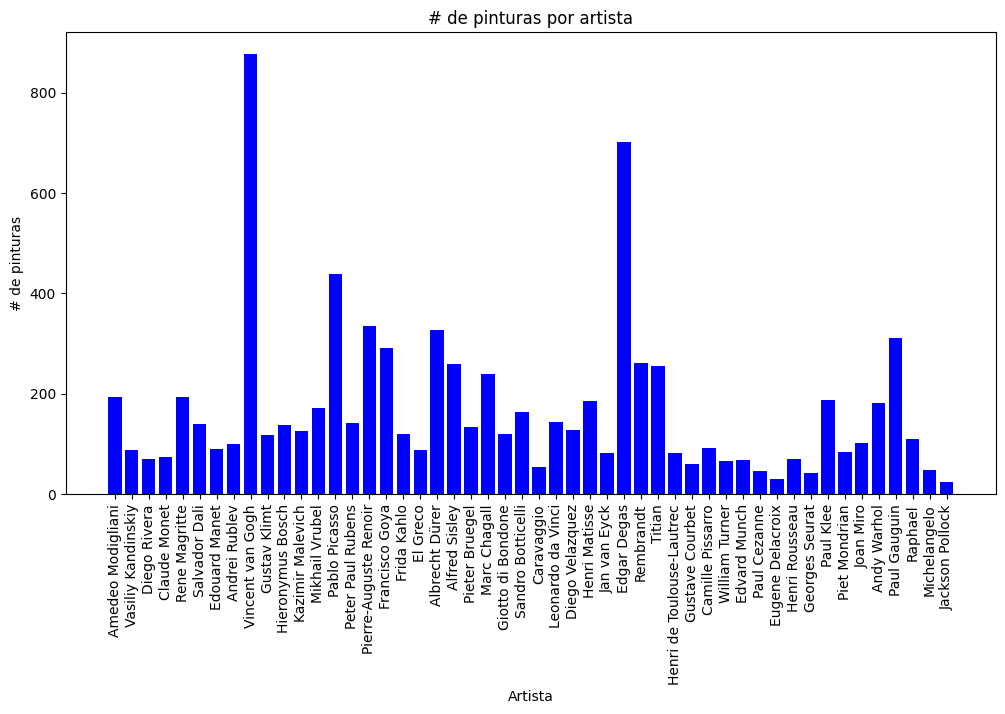

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df['name'], df['paintings'], color='blue')

plt.xlabel('Artista')
plt.ylabel('# de pinturas')
plt.title('# de pinturas por artista')
plt.xticks(rotation=90)

# Mostrar la gráfica
plt.show()

La información importante que nos da es que son 50 artistas y hay un gran desbalance en las clases. Por esta razón, se ha decidido que solamente se considerarán los 15 artistas con más pinturas, en este problema de clasificación. Trabajar con los 50 artistas se sugiere abordar en el futuro.

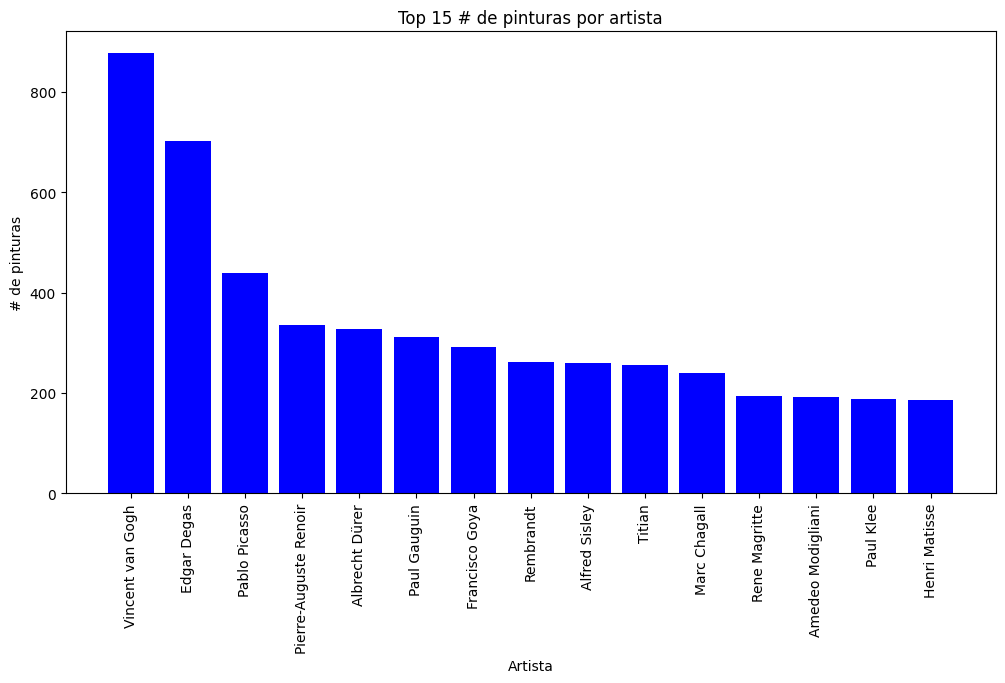

In [18]:
top15_df = df.sort_values(by='paintings', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.bar(top15_df['name'], top15_df['paintings'], color='blue')

plt.xlabel('Artista')
plt.ylabel('# de pinturas')
plt.title('Top 15 # de pinturas por artista')
plt.xticks(rotation=90)

plt.show()

**Objetivo: Crear una red neuronal convolucional para reconocer a 15 artistas extrayendo características fundamentales en las imágenes**

Para esto, se seguirán los siguientes pasos:

* **Organización de folders:** Organizar las carpetas de las imágenes, con tal de tener folders dedicados al entrenamiento, validación y prueba
* **Preprocesamiento:** Con keras.ImageDataGenerator preprocesar las imágenes para nuestra red CNN.
* **Diseño de arquitectura del modelo CNN:** Elegir la arquitectura del modelo CNN para hallar el mejor rendimiento posible sin encontrarse con overfitting o underfitting. 
* **Evaluación:** Evaluar el modelo con Acuraccy, top-2 Acuraccy, las curvas de entrenamiento y con matrices de confusión

# Organización

Para extraer los 15 artistas, se hizo manualmente selccionando las carpetas de esos artistas.
Se usó la función split_data para dividir los folders de prueba, entrenamiento y validación.

In [31]:
import numpy as np
import os
import shutil

# Función para dividir directorios
def split_data(source, train, test, test_ratio):
    classes = os.listdir(source)
    for cls in classes:
        cls_dir = os.path.join(source, cls)
        images = os.listdir(cls_dir)
        np.random.shuffle(images)
        test_size = int(len(images) * test_ratio)
        test_images = images[:test_size]
        train_images = images[test_size:]

        os.makedirs(os.path.join(train, cls), exist_ok=True)
        os.makedirs(os.path.join(test, cls), exist_ok=True)

        for img in test_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(test, cls, img))
        for img in train_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(train, cls, img))

Se decidió por esta distribución del dataset: 

**test: 15%** 

**train/val: 85%**
* **train: 75%**
* **validation: 25%** 

# Preprocesamiento

Se usó Keras y ImageDataGenerator. Debido a que el dataset no es muy grande, se optó por un DataAugmentation para el generador de entrenamiento.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# Directorios
val_dir = 'val_1'
# train_dir = 'train_1'
test_dir = 'test'
train_dir = 'train_1'

# Crear generador de datos con Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True)


# Generadores de datos para entrenamiento y validación
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
)

# Generador de datos para prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False 
)

# Ver las clases
print(train_generator.class_indices)

Found 3237 images belonging to 15 classes.
Found 1072 images belonging to 15 classes.
Found 751 images belonging to 15 classes.
{'Albrecht_Du╠êrer': 0, 'Alfred_Sisley': 1, 'Amedeo_Modigliani': 2, 'Edgar_Degas': 3, 'Francisco_Goya': 4, 'Henri_Matisse': 5, 'Marc_Chagall': 6, 'Pablo_Picasso': 7, 'Paul_Gauguin': 8, 'Paul_Klee': 9, 'Pierre-Auguste_Renoir': 10, 'Rembrandt': 11, 'Rene_Magritte': 12, 'Titian': 13, 'Vincent_van_Gogh': 14}


# Arquitecura modelo CNN

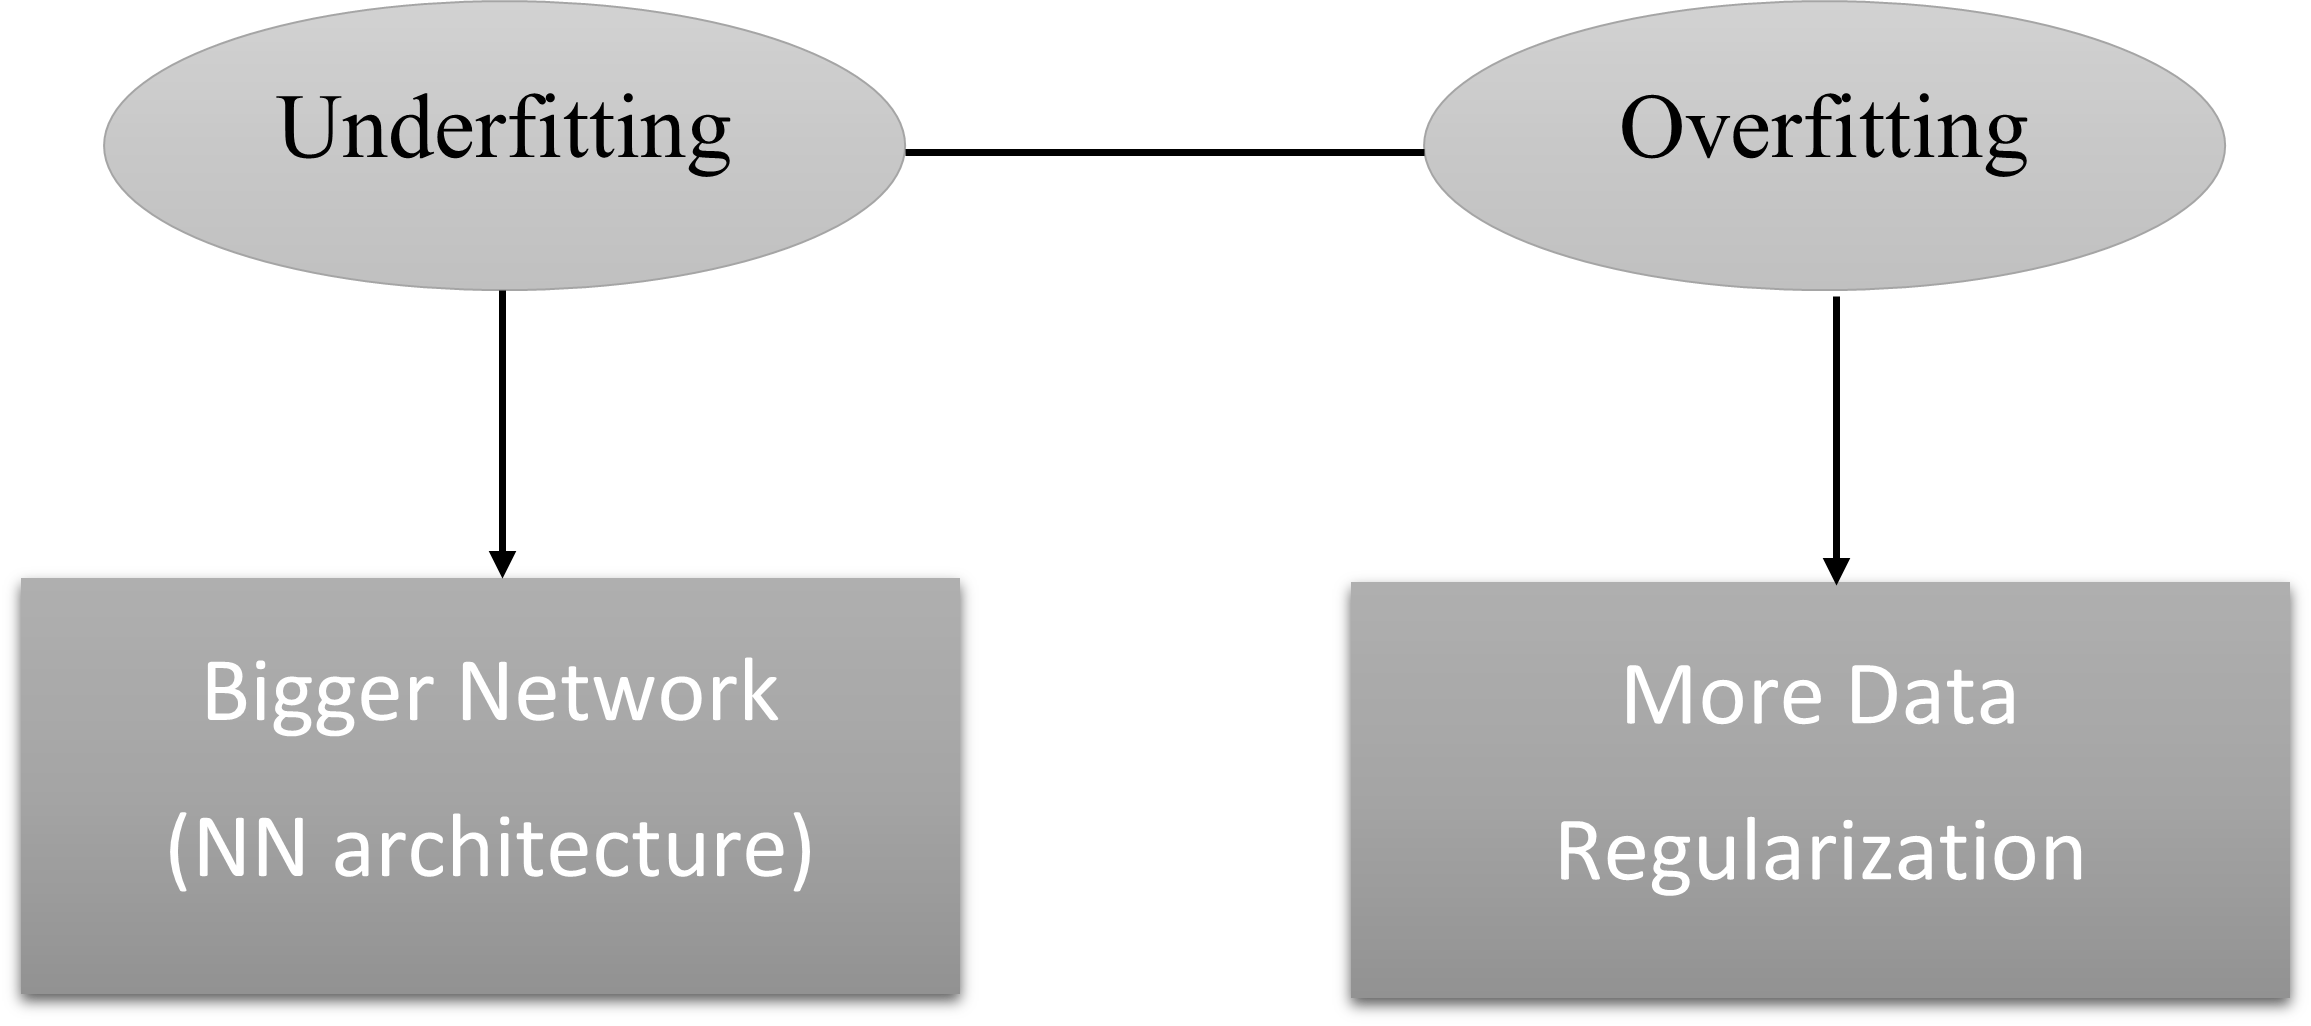

In [10]:
from PIL import Image

Image.open('Imagen1.png')


Herramientas usadas para la regularización:
* Dropout
* lrate decay
* BatchNormalization
* l2 

Para aumentar complejidad del modelo:
* Más capas convolucionales
* Más capas densas y más neuronas 


In [2]:
from keras.metrics import top_k_categorical_accuracy

# Definir función top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Definir función top-2 accuracy
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math
from keras.regularizers import l2
from keras.optimizers import RMSprop

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(256, (3, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Añadir una capa convolucional adicional y modificar las capas densas
model.add(Conv2D(512, (3, 3), padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation='softmax', dtype='float32'))

opt = RMSprop(learning_rate=1e-2)

# Compilar el modelo
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', top_3_accuracy, top_2_accuracy])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping y Top-k Accuracy
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[early_stopping, lrate]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_top_3_accuracy, test_top_2_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')
print(f'Test top-3 accuracy: {test_top_3_accuracy}')
print(f'Test top-2 accuracy: {test_top_2_accuracy}')

Epoch 1/100
177/177 [==============================] - 132s 680ms/step - loss: 5.9130 - accuracy: 0.0937 - top_3_accuracy: 0.2608 - top_2_accuracy: 0.1828 - val_loss: 2.6389 - val_accuracy: 0.0989 - val_top_3_accuracy: 0.3256 - val_top_2_accuracy: 0.2603 - lr: 0.0010
Epoch 2/100
177/177 [==============================] - 55s 307ms/step - loss: 2.6884 - accuracy: 0.1207 - top_3_accuracy: 0.3190 - top_2_accuracy: 0.2321 - val_loss: 4.0414 - val_accuracy: 0.0774 - val_top_3_accuracy: 0.2099 - val_top_2_accuracy: 0.1539 - lr: 0.0010
Epoch 3/100
177/177 [==============================] - 54s 304ms/step - loss: 2.6046 - accuracy: 0.1480 - top_3_accuracy: 0.3726 - top_2_accuracy: 0.2644 - val_loss: 2.5006 - val_accuracy: 0.1297 - val_top_3_accuracy: 0.4188 - val_top_2_accuracy: 0.2957 - lr: 0.0010
Epoch 4/100
177/177 [==============================] - 54s 302ms/step - loss: 2.5252 - accuracy: 0.1643 - top_3_accuracy: 0.3960 - top_2_accuracy: 0.2931 - val_loss: 2.4796 - val_accuracy: 0.1922 - 

In [1]:
"""Guardamos el modelo y la variable history """

model.save('guardar_model/modelo.h5')

# # GUARDAR
import pickle

with open('guardar_model/modelo.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [34]:
""" Cargamos el modelo ya entrenado con su objeto history """

from keras.models import load_model
import pickle

modelo = load_model('mejor_modelo.h5', custom_objects={'top_3_accuracy': top_3_accuracy, 'top_2_accuracy': top_2_accuracy})

#CARGAR mejor modelo


with open("mejor_modelo.pkl", 'rb') as file:
    historia = pickle.load(file)

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 64)    

In [6]:
"""Modelos anteriores"""
from keras.models import load_model
import pickle

modelo_prueba = 'guardar_model/modelo' # con clases balanceadas
# 'modelo_v1' # el primero modelo con una precisión prueba más de 50%



modelo = load_model(modelo_prueba + '.h5', custom_objects={'top_3_accuracy': top_3_accuracy, 'top_2_accuracy': top_2_accuracy})

with open(modelo_prueba + ".pkl", 'rb') as file:
    historia = pickle.load(file)

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 64)    

# Evaluación

46/46 [==============================] - 20s 307ms/step - loss: 1.6018 - accuracy: 0.5516 - top_3_accuracy: 0.7867 - top_2_accuracy: 0.7120


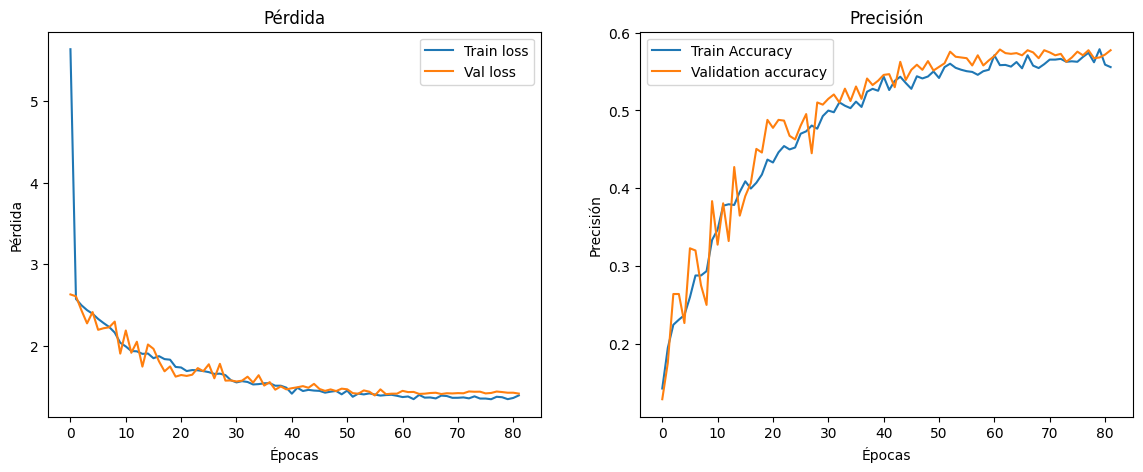

Test accuracy: 0.551630437374115
Test top-3 accuracy: 0.7866848111152649
Test top-2 accuracy: 0.7119565010070801


In [9]:
"""Evaluación de overfitting y underfitting con curvas de aprendizaje"""
import matplotlib.pyplot as plt

test_loss, test_accuracy, test_top_3_accuracy, test_top_2_accuracy = modelo.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)


# Curvas de entrenamiento
plt.figure(figsize=(14, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(historia['loss'], label='Train loss')
plt.plot(historia['val_loss'], label='Val loss')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(historia['accuracy'], label='Train Accuracy')
plt.plot(historia['val_accuracy'], label='Validation accuracy')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

print(f'Test accuracy: {test_accuracy}')
print(f'Test top-3 accuracy: {test_top_3_accuracy}')
print(f'Test top-2 accuracy: {test_top_2_accuracy}')


47/47 [==============================] - 5s 105ms/step


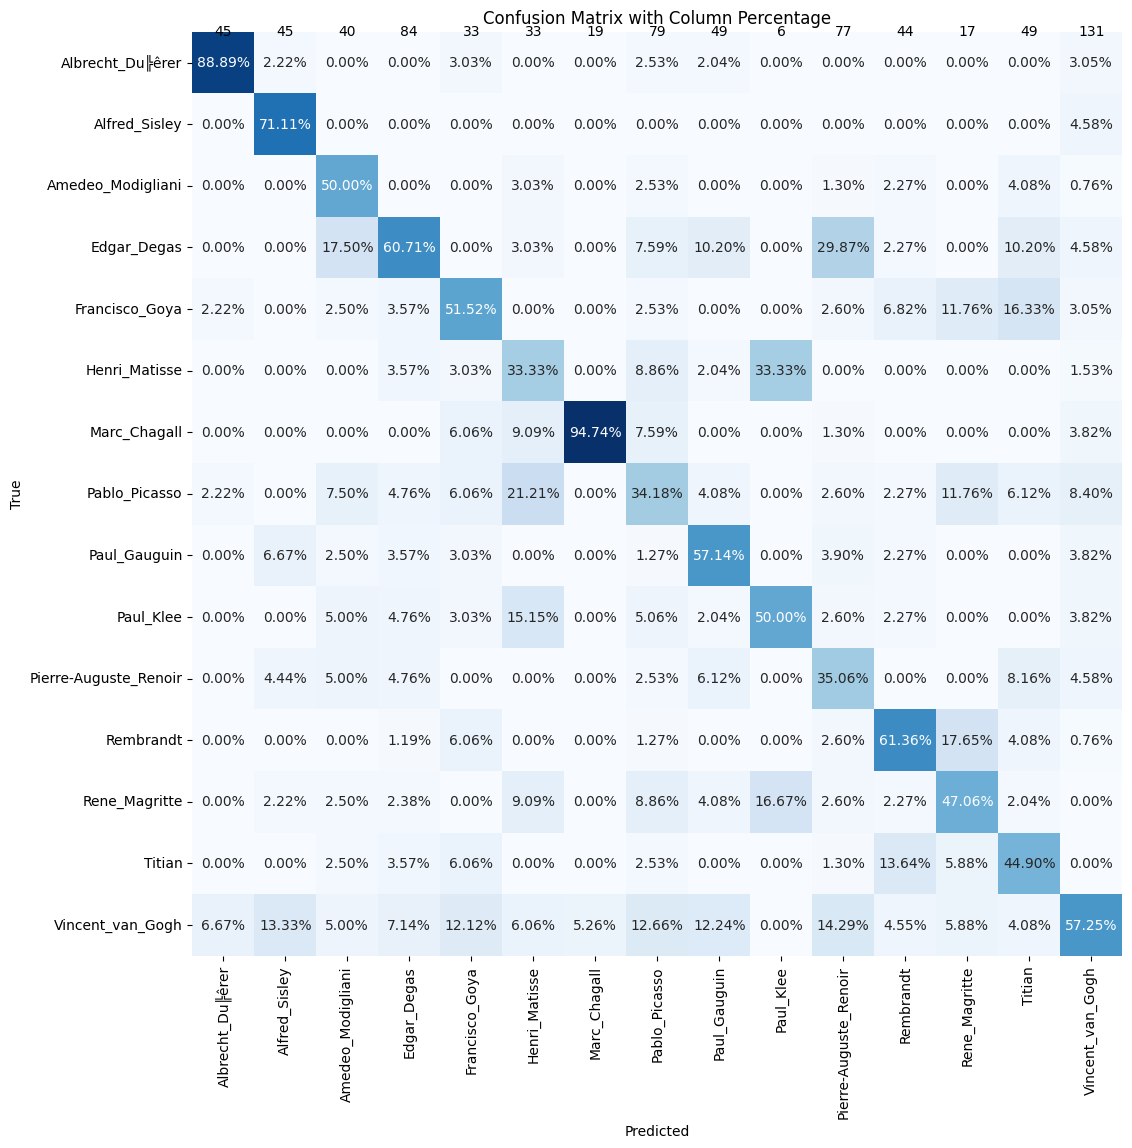

In [10]:
"""Matriz de confusión"""

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = modelo.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Normalizar por columna
cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]


fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', cbar=False, ax=ax)

for j in range(cm.shape[1]):
    ax.text(j + 0.5, 0, f'{cm.sum(axis=0)[j]}', horizontalalignment='center', verticalalignment='center', color='black')

plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Column Percentage')
plt.show()


47/47 [==============================] - 5s 109ms/step


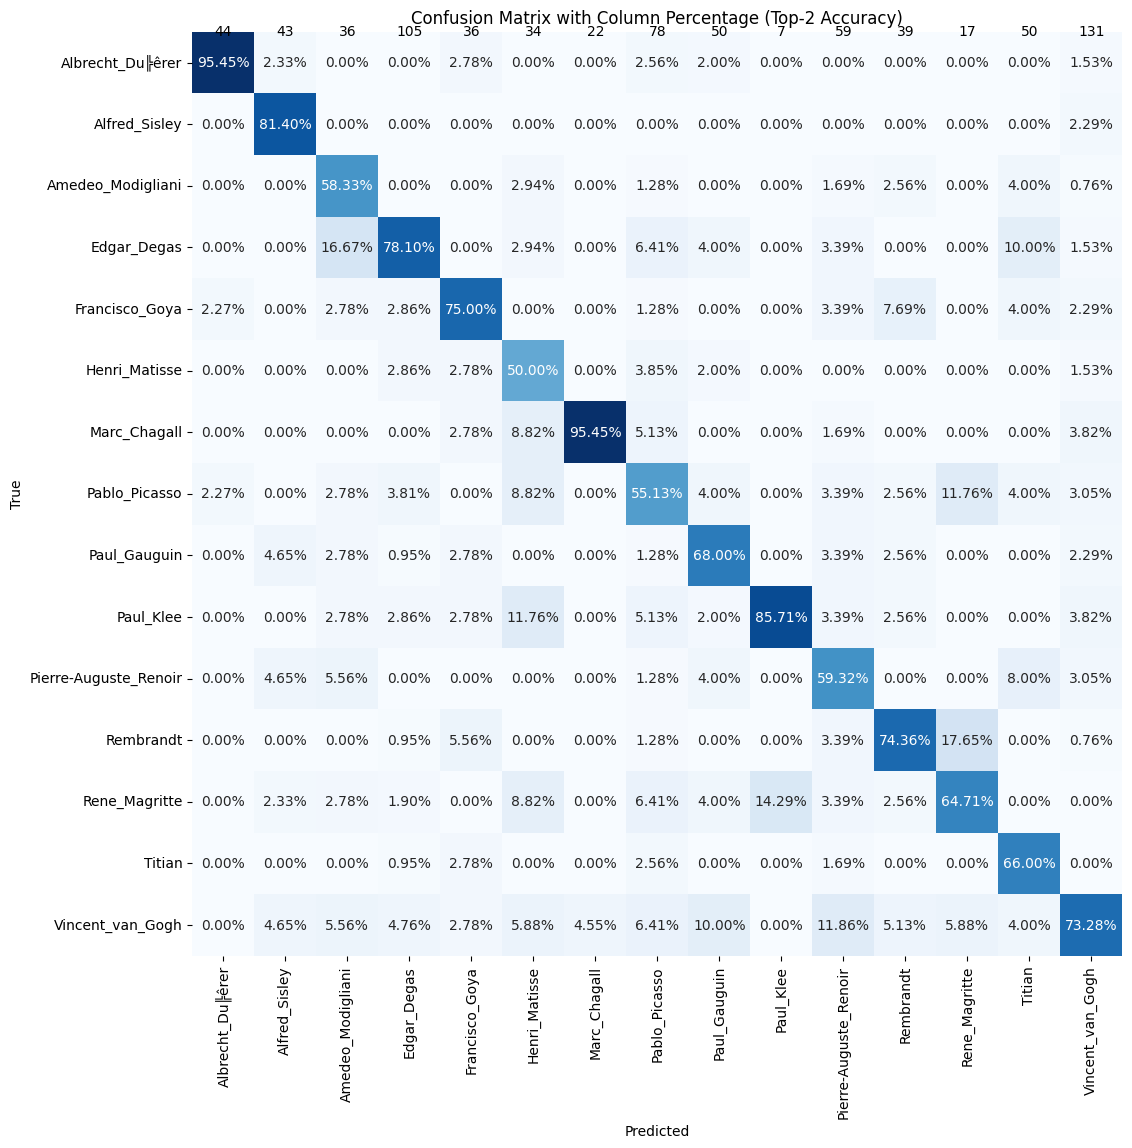

In [11]:
""" Matriz de confusión Top 2 """


predictions = modelo.predict(test_generator)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Obtener las top 2 predicciones para cada muestra
top_2_predictions = np.argsort(predictions, axis=1)[:, -2:]

cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# Rellenar la matriz de confusión
for i in range(len(true_classes)):
    true_class = true_classes[i]
    if true_class in top_2_predictions[i]:
        cm[true_class, true_class] += 1
    else:
        predicted_class = top_2_predictions[i, -1]  
        cm[true_class, predicted_class] += 1

# Normalizar por columna
cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]


fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', cbar=False, ax=ax)

for j in range(cm.shape[1]):
    ax.text(j + 0.5, 0, f'{cm.sum(axis=0)[j]}', horizontalalignment='center', verticalalignment='center', color='black')

plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Column Percentage (Top-2 Accuracy)')
plt.show()


# Visualización de capas

(1, 256, 256, 3)


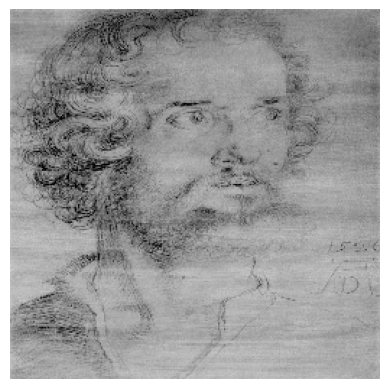

In [35]:
from keras import utils
import numpy as np


img_path = r'train_1\Albrecht_Du╠êrer\Albrecht_Du╠êrer_1.jpg'
# img_path = r'train_1\Vincent_van_Gogh\Vincent_van_Gogh_51.jpg'

#368
# ----- Preprocesamos la imagen en un tensor 4D

img = utils.load_img(img_path, target_size=(256, 256))
img_tensor = utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# ----- Debemos recordar que el modelo fue entrenado con imagenes de entrada preprocesadas de la siguiente manera:
img_tensor /= 255.

# Debemos ver que su forma es de (1, 150, 150, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.axis('Off')
plt.show()

modelo.layers[0].output

import tensorflow as tf
# Extraemos las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in modelo.layers[:8]]
# Creamos un modelo que devolverá estas salidas, dada la entrada al modelo:
activation_model = tf.keras.models.Model(inputs=modelo.input, outputs=layer_outputs)

1/1 [==============================] - 0s 129ms/step


C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_18504\1052937448.py:28: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_18504\1052937448.py:31: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


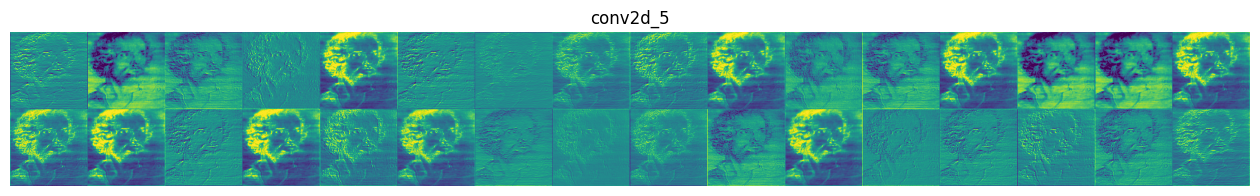

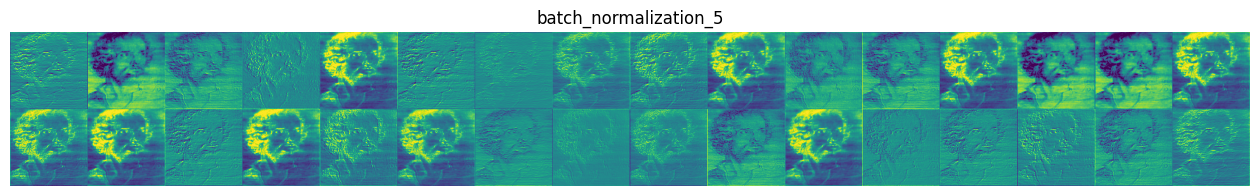

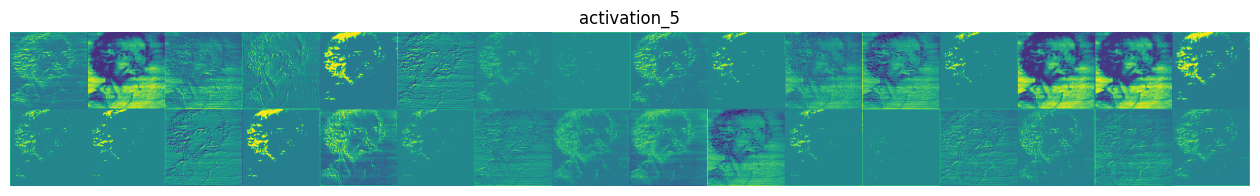

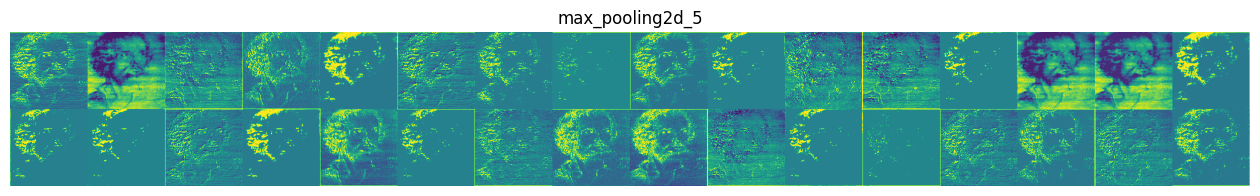

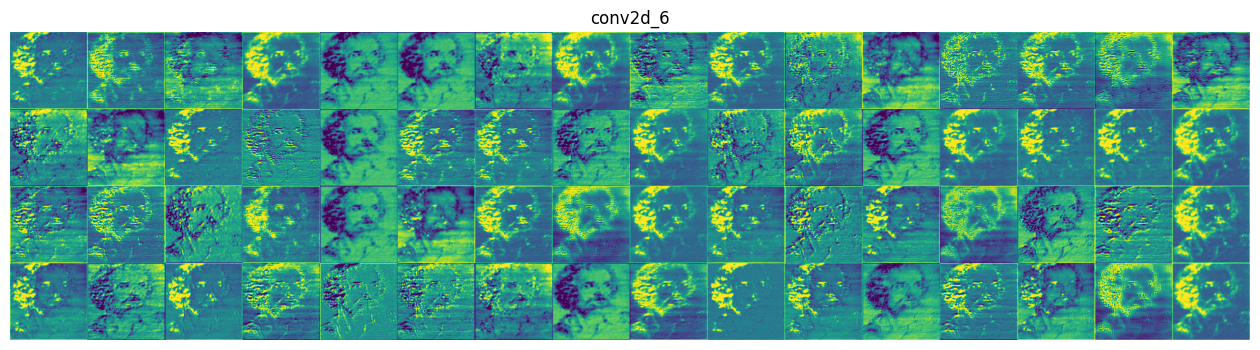

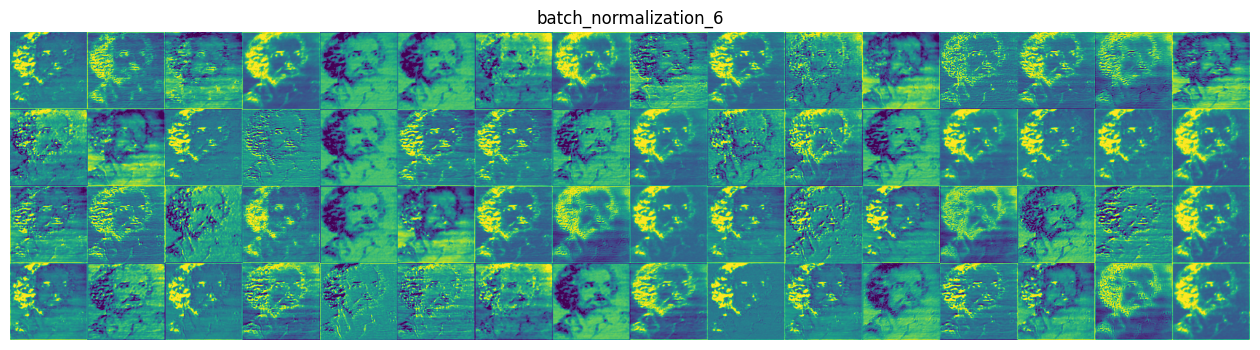

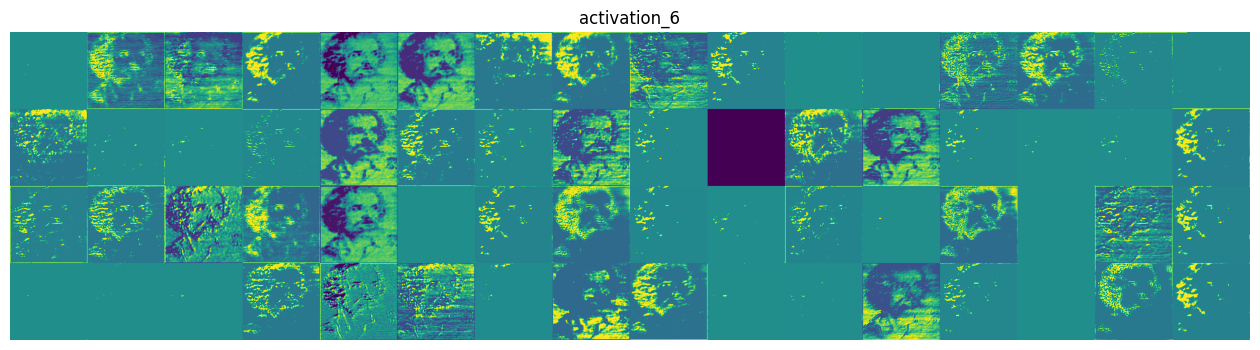

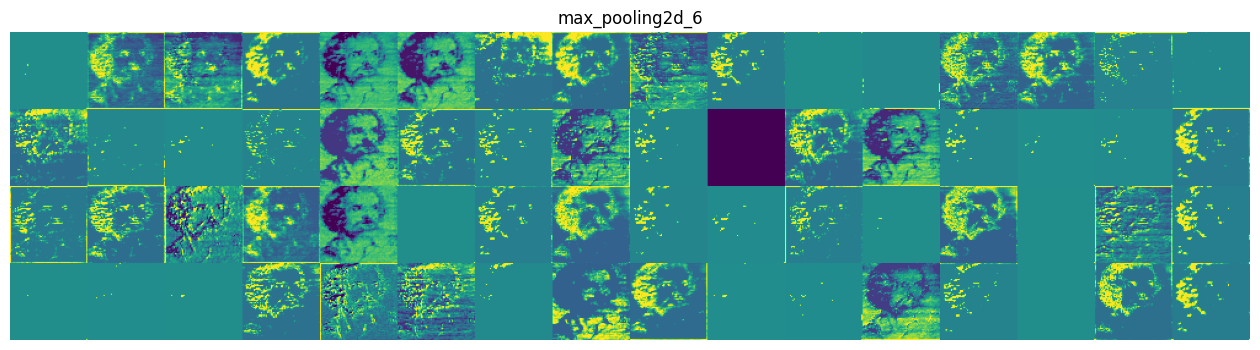

In [36]:
# Esto devolverá una lista de arreglos de Numpy: Un arreglo por capa de activación
activations = activation_model.predict(img_tensor)

layer_names = []
for layer in modelo.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for k,(layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
    # Este es el número de características presentes en un mapa de características
    n_features = layer_activation.shape[-1]

    # El mapa de características tiene la forma: (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Vamos a colocar los canales de activación en esta matriz
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Colocaremos cada mapa en esta gran malla horizontal
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            # Procesaremos el mapa de características para que sea visualmente agradable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Mostramos los mapas en la malla
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('Off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()